This notebook will feature and explain work by [Chris Rackauckas](http://chrisrackauckas.com/) who has accepted a position in Applied Math starting January 2019 at MIT.

This notebook features discussion of [Stochastic pdes on gpus](http://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/).

We also point out the remarkable [ODE Chart](http://www.stochasticlifestyle.com/comparison-differential-equation-solver-suites-matlab-r-julia-python-c-fortran/) comparing all kinds of solvers.




## 1. First the @. macro

Steven Johnson discusses the uses and performance reasons for what is known as "broadcasting" in his [more dots blog](https://julialang.org/blog/2017/01/moredots) from January 2017.  More recently, one has the opportunity to use fewer dots!

In [ ]:
o = ones(Int,5,5)

In [ ]:
o*o

In [ ]:
o.*o

In [ ]:
@. o*o

In [ ]:
exp(o)

In [ ]:
Σ = sum
Π = prod

In [ ]:
Σ( o^k / Π(1:k) for k ∈ 0:20 )

In [ ]:
ex = (:( (3)(!)))

In [ ]:
function foo(ex::Expr)
  if ex.args[3]==:!
    println(factorial(ex.args[2]))
  end
end

In [ ]:
macro fact(ex)
      if ex.args[3]==:!
       factorial(ex.args[2])
      end
end

In [ ]:
 @fact (3)(!)  

In [ ]:
dump(ex)

In [ ]:
@. exp(o)

In [ ]:
1:5 .> 3

In [ ]:
float.(1:5 .>3)

In [ ]:
@. float(1:5>3)

## 2. Next the Array Partition

In [ ]:
# using Pkg
# Pkg.add("RecursiveArrayTools")

In [ ]:
using RecursiveArrayTools

In [ ]:
# u = ArrayParition(A1,A2,A3,...)
# lets you get (A1,A2,...)[n][i,j]  by typing u[n,i,j]

In [ ]:
a = [1 2 3;4 5 6]
b = [7 8 9;10 11 12]
u = ArrayPartition(a,b)
u[2,1,3],  (a,b)[2][1,3]

In [ ]:
const N = 100
A = zeros(N,N); B  = zeros(N,N); C = zeros(N,N);
u0 = ArrayPartition((A,B,C))

## A difficult to understand differential equation (but only because of the notation and the jargon, actually it's not so bad.)

$$A_t=DΔA+α_A(x)−β_AA−r_1AB+r_2 C$$
$$B_t=α_B−β_BB−r_1AB+r_2C $$
$$C_t=α_C−β_CC+r_1AB−r_2C$$

This is a PDE on a 2d grid evolving in time. 

$A,B,C$ are functions of x,y discretized as 2d arrays.
The time derivatives $A_t,B_t,C_t$ are also functions of x,y discretized as 2d arrays.

Δ is the ordinary Laplacian : $\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}.$ <br>
On a discretized grid of unit step size this is  sum of my NEWS neighbors (north,east,...) - 4*me

All the other variables are scalars, mostly independent of time and space except for the first $\alpha$ which will depend on the x coordinate (and can be stored as a vector, not a matrix, but not what he did in the code)

I kind of wish all scalar constants were small Latin or Greek letters but anyway ...

In [ ]:
const D = 100  # D makes me think derivative, wish it weren't used
const α₂,α₃    = 1.0, 1.0      # Change in notation from α_B and  α_C probably because unavailable in unicode
const β₁,β₂,β₃ = 1.0, 1.0, 1.0 # Change in notation from β with subscripts A,B,C
const r₁,r₂ = 1.0, 1.0

In [ ]:
N = 100
#const X = reshape([i for i in 1:100 for j in 1:100],N,N)
#const Y = reshape([j for i in 1:100 for j in 1:100],N,N)
const X = [i for i∈1:N, j∈1:N]
const Y = X'
const α₁ = float.(X.≥80); # We will make it 1 if X≥80  (Not constant in space, but constant as an array)

## The Tridiagonal Approach to the Laplacian

In [ ]:
using LinearAlgebra

In [ ]:
Mx = Tridiagonal(ones(Int,N-1), fill(-2,N), ones(Int,N-1))
Mx[2,1] = 2
Mx[end-1,end] = 2
My = Mx'

In [ ]:
A = zeros(Int,N,N)
A[3,3]=1
A

In [ ]:
# sum of my NEWS neighbors (north,east,...) - 4*me
Mx*A + A*My

In [ ]:
# The reflecting conditions
A = zeros(Int,N,N)
A[1,1]=1
A[1,5]=1
A[1,100]=1
A
Mx*A + A*My

Discussion --- storing all these numbers on the tridiagonal, using matmul???

## Evaluating the RHSs

In [ ]:
function f(du,u,p,t)
  A,B,C = u.x
  dA,dB,dC = du.x
  DA = D*(M*A + A*M)
  ## The time changes
  @. dA = DA + α₁ - β₁*A - r₁*A*B + r₂*C 
  @. dB = α₂ - β₂*B - r₁*A*B + r₂*C
  @. dC = α₃ - β₃*C + r₁*A*B - r₂*C
end

Some comments:
The M here should be Mx and My <br>
Possible the D* should be D.* but the @. would ruin the matmul (perhaps another reason matmul seems odd) <br>
Aha he remarks in the comments that non matmul is better <br>
Otherwise the steps are written in a "data parallel" manner

## Running the code in 1.0

In [ ]:
#using Pkg
#Pkg.add("OrdinaryDiffEq")

In [ ]:
#######################################################
### Solve the PDE
#######################################################
 
using OrdinaryDiffEq, RecursiveArrayTools, LinearAlgebra
 
# Define the constants for the PDE
const α₂ = 1.0
const α₃ = 1.0
const β₁ = 1.0
const β₂ = 1.0
const β₃ = 1.0
const r₁ = 1.0
const r₂ = 1.0
const D = 100.0
const γ₁ = 0.1
const γ₂ = 0.1
const γ₃ = 0.1
const N = 100
#const X = reshape([i for i in 1:100 for j in 1:100],N,N)
#const Y = reshape([j for i in 1:100 for j in 1:100],N,N)
#const α₁ = 1.0.*(X.>=80)
const X = [i for i∈1:N, j∈1:N]
const Y = [j for i∈1:N, j∈1:N]
const α₁ = float.(X.≥80)
 
#const Mx = full(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
const Mx = Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1])
const My = copy(Mx)
Mx[2,1] = 2.0
Mx[end-1,end] = 2.0
My[1,2] = 2.0
My[end,end-1] = 2.0
 
# Define the initial condition as normal arrays
A = zeros(N,N); B  = zeros(N,N); C = zeros(N,N)
u0 = ArrayPartition((A,B,C))
 
const MyA = zeros(N,N);
const AMx = zeros(N,N);
const DA = zeros(N,N)
# Define the discretized PDE as an ODE function
function f(du,u,p,t)
  A,B,C = u.x
  dA,dB,dC = du.x
  mul!(MyA,My,A)
  mul!(AMx,A,Mx)
  @. DA = D*(MyA + AMx)
  @. dA = DA + α₁ - β₁*A - r₁*A*B + r₂*C
  @. dB = α₂ - β₂*B - r₁*A*B + r₂*C
  @. dC = α₃ - β₃*C + r₁*A*B - r₂*C
end
 
# Solve the ODE
prob = ODEProblem(f,u0,(0.0,100.0))
@time sol = solve(prob,BS3(),progress=true,save_everystep=false,save_start=false)
 
using Plots; pyplot()
p1 = surface(X,Y,sol[end].x[1],title = "[A]")
p2 = surface(X,Y,sol[end].x[2],title = "[B]")
p3 = surface(X,Y,sol[end].x[3],title = "[C]")

 
#######################################################
### Solve the PDE using CLArrays
#######################################################
 
# using CLArrays
# gA = CLArray(A); gB  = CLArray(B); gC = CLArray(C)
# const gMx = CLArray(Mx)
# const gMy = CLArray(My)
# const gα₁ = CLArray(α₁)
# gu0 = ArrayPartition((gA,gB,gC))

# const gMyA = CLArray(MyA)
# const gAMx = CLArray(AMx)
# const gDA = CLArray(DA)
# function gf(du,u,p,t)
#   A,B,C = u.x
#   dA,dB,dC = du.x
#   mul!(gMyA,gMy,A)
#   mul!(gAMx,A,gMx)
#   @. gDA = D*(gMyA + gAMx)
#   @. dA = gDA + gα₁ - β₁*A - r₁*A*B + r₂*C
#   @. dB = α₂ - β₂*B - r₁*A*B + r₂*C
#   @. dC = α₃ - β₃*C + r₁*A*B - r₂*C
# end

# prob2 = ODEProblem(gf,gu0,(0.0,100.0))
# GPUArrays.allowslow(false)
# @time sol = solve(prob2,BS3(),progress=true,dt=0.003,adaptive=false,save_everystep=false,save_start=false)

# prob2 = ODEProblem(gf,gu0,(0.0,100.0))
# sol = solve(prob2,BS3(),progress=true,save_everystep=false,save_start=false)
# Adaptivity currently fails due to https://github.com/JuliaGPU/CLArrays.jl/issues/10
 
#######################################################
### Solve the SPDE
#######################################################
 


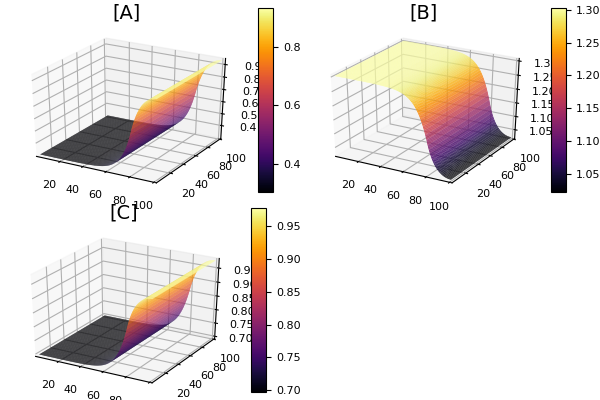

In [2]:
plot(p1,p2,p3)

In [7]:
using StochasticDiffEq
 
function g(du,u,p,t)
  A,B,C = u.x
  dA,dB,dC = du.x
  @. dA = γ₁*A
  @. dB = γ₂*A
  @. dC = γ₃*A
end
 
prob3 = SDEProblem(f,g,u0,(0.0,100.0))
sol = solve(prob3,SRIW1(),progress=true,save_everystep=false,save_start=false)
 
# p1 = surface(X,Y,sol[end].x[1],title = "[A]")
# p2 = surface(X,Y,sol[end].x[2],title = "[B]")
# p3 = surface(X,Y,sol[end].x[3],title = "[C]")


DimensionMismatch: DimensionMismatch("array could not be broadcast to match destination")

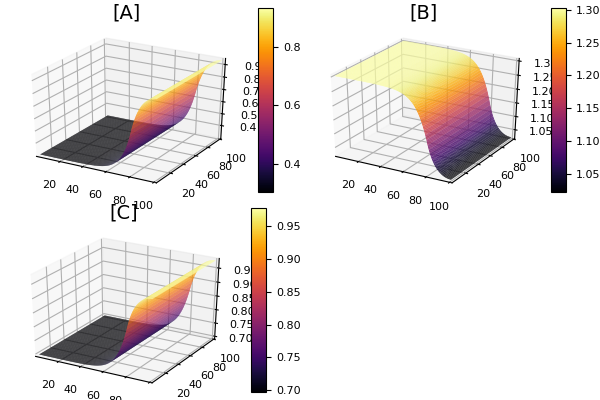

In [4]:
plot(p1,p2,p3)